
**CS 403 project: Density-weighted support vector machines for binary class imbalance learning**

[paper link](https://link.springer.com/article/10.1007/s00521-020-05240-8)


---


**Instuctions to run the notebook:**

Add a shortcut of the 'CS_403_project_files' folder ([link](https://drive.google.com/drive/folders/1dQugKuL-zx1mXT4NcWCNCz1W2tdqMYRR?usp=sharing)) and mount the drive

Run the following sections-

1.   **Initialization**
  *   Set the dataset no., the over_or_under no. (oversampling or undersampling or combined technique to be used) and model no. from the 'datasets', 'over_or_under' and 'models' lists respectively
  *   Paste the path to the shortcut of the 'CS_403_project_files' folder
  *   (Optional) Set hyperparameters
      1.   split_ratio (test-train ratio)
      2.   train_IR (desired imbalance ratio of the training dataset)
      3.   C (penalty parameter)
      4.   mu (for the RBF kernel)

          OR the optimized parameters mentioned in the paper will be used as default
      5.   E (regularization term only for IDLSSVM-CIL)
      6. desired_ratio (desired imbalance ratio of the training dataset after sampling (if applicable))
  
2.   **Loading the Dataset**

3.   **Normalization (min-max scaling)**

4.   **(Optional) Applying RBF kernel (only visualization)**

5.   **Train-test-split**

6.   **Oversampling or Undersampling (with visualization)**

7.   **Defining Helper Functions**

8.   Based on the 'model_no' selected, one of the following model will be trained and used for prediction
  *   **Support Vector Machine (SVM)**
  *   **Least squares SVM (LSSVM)**
  *   **IDLSSVM-CIL**

9.   **Results**

# Initialization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import time
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [93]:
datasets = ['04clover5z-600-5-50-BI.dat','04clover5z-600-5-70-BI.dat','paw02a-600-5-0-BI.dat','paw02a-600-5-70-BI.dat','paw02a-800-7-30-BI.dat']
over_or_under = ['None', 'SMOTE', 'Borderline_SMOTE', 'KMeans_SMOTE', 'ADASYN', 'Near-Miss', 'Condensed_NN', 'TomekLinks', 'SMOTEENN', 'SMOTETomek']
models = ['SVM', 'LSSVM', 'IDLSSVM-CIL']

folder_path = "/content/drive/MyDrive/CS_403_project_files"

dataset_no = 2 # 0 to 4
over_or_under_no = 2 # 0:No sampling; (1 to 4):oversampling; (5 to 7):undersampling; (8 to 9):combined
model_no = 2 # 0 to 2

split_ratio = 0.3
optimized_params = [[(0.2034, 10**1, 2**(-2)), (0.2034, 10**2, 2**(-4)), (0.2034, 10**4, 2**(-4))],
    [(0.1932, 10**2, 2**(-2)), (0.1932, 10**0, 2**(-2)), (0.1932, 10**2, 2**(-2))],
    [(0.2068, 10**3, 2**(-2)), (0.2068, 10**1, 2**(-3)), (0.2068, 10**1, 2**(-3))],
    [(0.2, 10**2, 2**(-1)), (0.2, 10**1, 2**(-2)), (0.2, 10**1, 2**(-2))],
    [(0.1429, 10**0, 2**(-3)), (0.1429, 10**3, 2**(-3)), (0.1429, 10**2, 2**(-3))]]
train_IR, C, mu = optimized_params[dataset_no][model_no] # C>0
E = 0.1 # only for IDLSSVM-CIL
desired_ratio = 0.6 # not applicable for 'Condensed_NN' & 'TomekLinks'

print("Dataset selected:",datasets[dataset_no], "\nSampling Technique:",over_or_under[over_or_under_no],"\nModel selected:",models[model_no])

Dataset selected: paw02a-600-5-0-BI.dat 
Sampling Technique: Borderline_SMOTE 
Model selected: IDLSSVM-CIL


# Loading the Dataset

In [94]:
file_path = folder_path + "/keel_datasets/" + datasets[dataset_no]
df = pd.read_csv(file_path, header=None, names=['feature1', 'feature2', 'class'])
df = df.iloc[7:].reset_index(drop=True).astype(int)
display(df)

counts = df['class'].value_counts()
df_IR = counts[0]/counts[1]
print("\nImbalance Ratio (all data):",'{:.2f}'.format(df_IR),"\n")
print(counts)

,feature1,feature2,class
0,358,400,0
1,404,387,0
2,413,295,0
3,425,431,0
4,415,294,0
...,...,...,...
595,487,182,1
596,433,549,1
597,52,307,1
598,374,943,1



Imbalance Ratio (all data): 0.20 

class
1    500
0    100
Name: count, dtype: int64


# Normalization

In [95]:
min_values = df.min()
max_values = df.max()
df['feature1'] = (df['feature1'] - int(min_values[0])) / (int(max_values[0]) - int(min_values[0]))
df['feature2'] = (df['feature2'] - int(min_values[1])) / (int(max_values[1]) - int(min_values[1]))

# Applying RBF kernel (only for visualization)

In [96]:
from sklearn.kernel_approximation import RBFSampler
rbf_sampler = RBFSampler(gamma=mu, n_components=2, random_state=42)

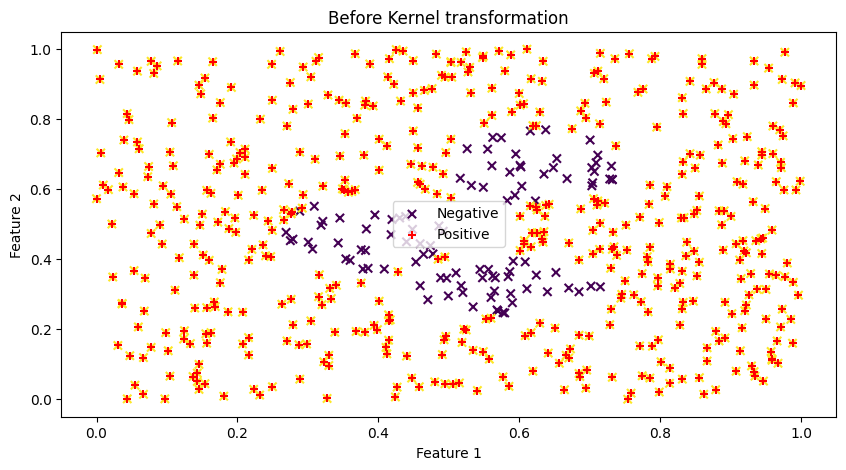

In [97]:
plt.figure(figsize=(10, 5))
plt.scatter(df['feature1'], df['feature2'], c=df['class'], marker='x', label='Negative')
plt.scatter(df['feature1'][df['class'] == 1], df['feature2'][df['class'] == 1], c='r', marker='+', label='Positive')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Before Kernel transformation')
plt.legend()
plt.show()

In [98]:
trans_X = rbf_sampler.fit_transform(df[['feature1', 'feature2']])
trans_df = pd.DataFrame(trans_X, columns=['RBF_1', 'RBF_2'])
trans_df['class'] = df['class']

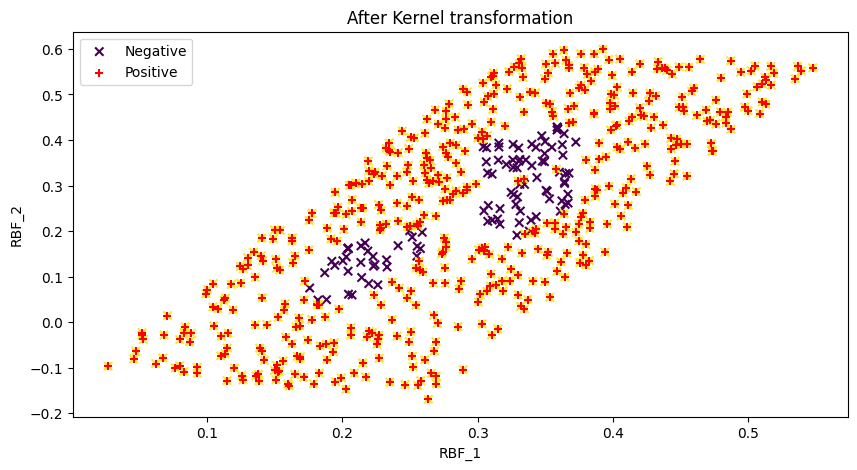

In [99]:
plt.figure(figsize=(10, 5))
plt.scatter(trans_df['RBF_1'], trans_df['RBF_2'], c=trans_df['class'], marker='x', label='Negative')
plt.scatter(trans_df['RBF_1'][trans_df['class'] == 1], trans_df['RBF_2'][trans_df['class'] == 1], c='r', marker='+', label='Positive')
plt.xlabel('RBF_1')
plt.ylabel('RBF_2')
plt.title('After Kernel transformation')
plt.legend()
plt.show()

# Train-test-split

In [100]:
df_1 = df[df['class'] == 1]
df_0 = df[df['class'] == 0]

train_size = int(df.shape[0]*(1-split_ratio))
num_train_0 = int((train_size*train_IR)/(1+train_IR))

df_train_0 = df_0.sample(n=num_train_0, random_state=42)
df_train_1 = df_1.sample(n=(train_size-num_train_0), random_state=42)
df_test_0 = df_0.drop(df_train_0.index)
df_test_1 = df_1.drop(df_train_1.index)

df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)
df_test = pd.concat([df_test_0, df_test_1], ignore_index=True)

X_train = df_train.iloc[:, :2].values
y_train = df_train.iloc[:,2].values
X_test = df_test.iloc[:, :2].values
y_test = df_test.iloc[:,2].values

# Oversampling or Undersampling (with visualization)

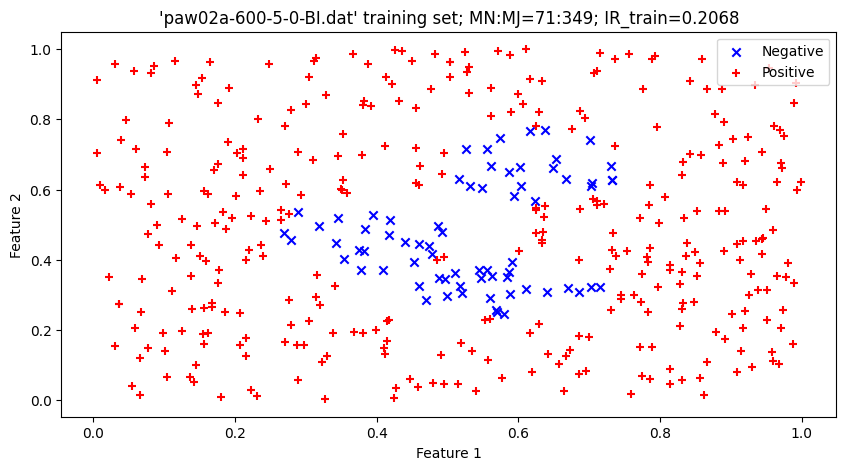

In [101]:
plot_title_1 = "'" + str(datasets[dataset_no]) + "' training set; MN:MJ=" + str(np.sum(y_train == 0)) + ":" + str(np.sum(y_train == 1)) + "; IR_train=" + str(train_IR)
negative_samples = X_train[y_train == 0]
positive_samples = X_train[y_train == 1]
plt.figure(figsize=(10, 5))
plt.scatter(negative_samples[:, 0], negative_samples[:, 1], c='b', marker='x', label='Negative')
plt.scatter(positive_samples[:, 0], positive_samples[:, 1], c='r', marker='+', label='Positive')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(plot_title_1)
plt.legend()
plt.show()

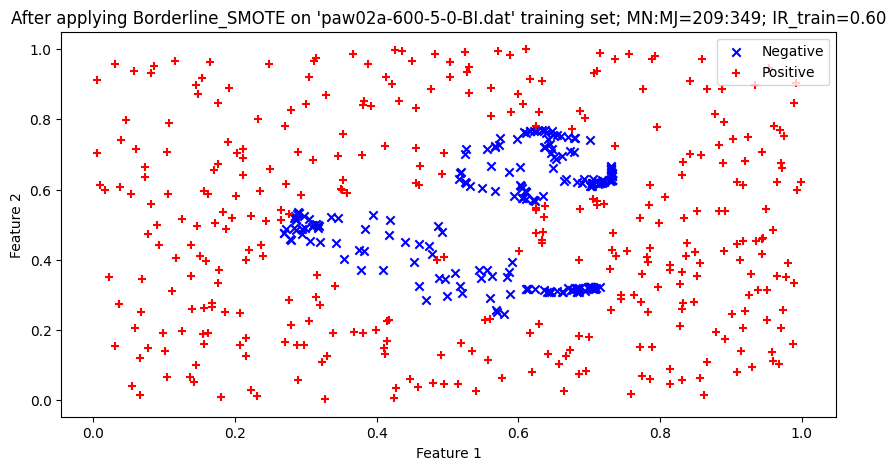

In [102]:
if over_or_under_no > 0:

  if over_or_under_no==1:
    sampling = SMOTE(sampling_strategy=desired_ratio, k_neighbors=5)

  elif over_or_under_no==2:
    sampling = BorderlineSMOTE(sampling_strategy=desired_ratio, k_neighbors=5)

  elif over_or_under_no==3:
    sampling = KMeansSMOTE(cluster_balance_threshold=0.2, sampling_strategy=desired_ratio, k_neighbors=2, kmeans_estimator=MiniBatchKMeans())

  elif over_or_under_no==4:
    sampling = ADASYN(sampling_strategy=desired_ratio)

  elif over_or_under_no==5:
    sampling = NearMiss(sampling_strategy=desired_ratio)

  elif over_or_under_no==6:
    sampling = CondensedNearestNeighbour()

  elif over_or_under_no==7:
    sampling = TomekLinks()

  elif over_or_under_no==8:
    sampling = SMOTEENN(sampling_strategy=desired_ratio)

  elif over_or_under_no==9:
    sampling = SMOTETomek(sampling_strategy=desired_ratio)

  X_train, y_train = sampling.fit_resample(X_train, y_train)
  train_IR = np.sum(y_train == 0)/np.sum(y_train == 1)

  plot_title_2 = "After applying " + str(over_or_under[over_or_under_no]) + " on '" + str(datasets[dataset_no]) + "' training set; MN:MJ=" + str(np.sum(y_train == 0)) + ":" + str(np.sum(y_train == 1)) + "; IR_train=" + str('{:.2f}'.format(train_IR))
  negative_samples = X_train[y_train == 0]
  positive_samples = X_train[y_train == 1]
  plt.figure(figsize=(10, 5))
  plt.scatter(negative_samples[:, 0], negative_samples[:, 1], c='b', marker='x', label='Negative')
  plt.scatter(positive_samples[:, 0], positive_samples[:, 1], c='r', marker='+', label='Positive')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title(plot_title_2)
  plt.legend()
  plt.show()

# Defining Helper Functions

![picture](https://drive.google.com/uc?export=view&id=13Itx1Hlu0_Nbe3Eq73QwynV9HNP5wovg)

In [103]:
def rbf(x_i, x_j, sigma):
  return np.exp((-cdist(x_i, x_j)**2)/ sigma**2)

![picture](https://drive.google.com/uc?export=view&id=1A8Cf3HsU0b7kXDUVb5p9HIbvIQE91348)

In [104]:
def compute_density_weight(X):
  nn_model = NearestNeighbors(n_neighbors=5)
  nn_model.fit(X)
  distances, _ = nn_model.kneighbors(X)
  kth_neighbor_distances = distances[:, -1]
  d = 1 - (kth_neighbor_distances/np.max(kth_neighbor_distances))
  D_ = np.diag(d, k=0)
  return D_

In [105]:
def make_meshgrid(h):
  xx, yy = np.meshgrid(np.arange(0, 1, h), np.arange(0, 1, h))
  return xx, yy

# Support Vector Machine (SVM)

![picture](https://drive.google.com/uc?export=view&id=1wwZ44sr-kgJIb2eDCAngJVfHon2uCAHV)

In [106]:
if model_no==0:
  start_time = time.time()
  SVM_model = svm.SVC(C = C, kernel='rbf', gamma = mu, class_weight='balanced')
  SVM_model.fit(X_train, y_train)
  y_pred = SVM_model.predict(X_test)
  end_time = time.time()
  computation_time = end_time - start_time

# Least squares SVM (LSSVM)

![picture](https://drive.google.com/uc?export=view&id=1OfA82Thy4_2FG8QsUqEGzA_CPmPcxw7c)


In [107]:
def fit_lssvm(X, y, C_, mu_):

  y = y.reshape(-1,1) if y.ndim==1 else y
  y_labels = np.unique(y, axis=0)
  y = np.where((y == y_labels[0]).all(axis=1),-1,+1)[:,np.newaxis]

  K = rbf(X,X,mu_)
  sigma = np.multiply(y*y.T, K)
  A = np.block([[0, y.T], [y, sigma + C_**-1 *np.eye(len(y))]])
  B = np.array([0]+[1]*len(y))

  A_inv = np.linalg.pinv(A)
  solution = np.dot(A_inv, B)
  b_ = solution[0]
  alpha_ = solution[1:]

  return (alpha_, b_)

![picture](https://drive.google.com/uc?export=view&id=12Sl-k4uOmjbFEisBuIhKDFXW11eLmfp6)

In [108]:
def predict_lssvm(sv_X, X, y, alpha_, b_, mu_):

  X_reshaped = X.reshape(1,-1) if X.ndim==1 else X
  y = y.reshape(-1,1) if y.ndim==1 else y
  y_labels = np.unique(y, axis=0)
  y = np.where((y == y_labels[0]).all(axis=1),-1,+1)[:,np.newaxis]

  KxX = rbf(sv_X, X_reshaped, mu_)
  y = np.sign(np.dot(np.multiply(alpha_, y.flatten()), KxX) + b_)
  y_pred_labels = np.where(y==-1, y_labels[0], y_labels[1])

  return y_pred_labels

In [109]:
if model_no==1:
  start_time = time.time()
  alpha, b = fit_lssvm(X_train, y_train, C, mu)
  y_pred = predict_lssvm(X_train, X_test, y_train, alpha, b, mu)
  end_time = time.time()
  computation_time = end_time - start_time

# IDLSSVM-CIL


![picture](https://drive.google.com/uc?export=view&id=1ZMdztV8Pkl2IQDi47hh01hJ34-vQ5MpE)


In [110]:
def fit_idlssvmcil(X, y, D, C_, mu_, E_):
  y = y.reshape(-1,1) if y.ndim==1 else y
  y_labels = np.unique(y, axis=0)
  y = np.where((y == y_labels[0]).all(axis=1),-1,+1)[:,np.newaxis]

  K = rbf(X,X,mu_)
  DTD = D.T*D
  DTD_inv = np.linalg.pinv(DTD)
  DTD_inv = (C_**-1)*DTD_inv + (E_)*np.eye(len(y))
  sigma = np.multiply(y*y.T, K)
  A = np.block([[0, y.T], [y, sigma + DTD_inv]])
  B = np.array([0]+[1]*len(y))

  A_inv = np.linalg.pinv(A)
  solution = np.dot(A_inv, B)
  b_ = solution[0]
  alpha_ = solution[1:]

  return (alpha_, b_)

![picture](https://drive.google.com/uc?export=view&id=1I4lN4utehXsG7wnoaFAhifrAudSkGrP2)

In [111]:
def predict_idlssvmcil(sv_X, X, y, alpha_, b_, mu_):

  X_reshaped = X.reshape(1,-1) if X.ndim==1 else X
  y = y.reshape(-1,1) if y.ndim==1 else y
  y_labels = np.unique(y, axis=0)
  y = np.where((y == y_labels[0]).all(axis=1),-1,+1)[:,np.newaxis]

  KxX = rbf(sv_X, X_reshaped,mu_)
  y = np.sign(np.dot(np.multiply(alpha_, y.flatten()), KxX) + b_)
  y_pred_labels = np.where(y==-1, y_labels[0], y_labels[1])

  return y_pred_labels

In [112]:
if model_no==2:
  start_time = time.time()
  D = compute_density_weight(X_train)
  alpha, b = fit_idlssvmcil(X_train, y_train, D, C, mu, E)
  y_pred = predict_idlssvmcil(X_train, X_test, y_train, alpha, b, mu)
  end_time = time.time()
  computation_time = end_time - start_time

# Results

AUC and G-mean are calculated as in *Hazarika, Barenya Bikash, and Deepak Gupta. "Density-weighted support vector machines for binary class imbalance learning." Neural Computing and Applications 33.9 (2021): 4243-4261.*

In [113]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
auc = ((1 + (tp/(tp + fn)) - (fp/(tn + fp)))/2)*100
g_mean = ((tp/(tp + fp)) * (tp/(tp + fn)))**0.5
test_acc = ((tp + tn)/(tp + tn + fp + fn))*100
print("Test Dataset:", datasets[dataset_no], "\nSampling technique used:", over_or_under[over_or_under_no], "; train_data_IR:", '{:.2f}'.format(train_IR), "\nModel:", models[model_no], "\nC:",C,"; mu:",mu,"\ntime (in s):", '{:.4f}'.format(computation_time),
      "\nAUC:", '{:.4f}'.format(auc),"%\nG-mean:",'{:.5f}'.format(g_mean),"\ntest_acc:", '{:.2f}'.format(test_acc),"%")

Test Dataset: paw02a-600-5-0-BI.dat 
Sampling technique used: Borderline_SMOTE ; train_data_IR: 0.60 
Model: IDLSSVM-CIL 
C: 10 ; mu: 0.125 
time (in s): 0.3203 
AUC: 97.0199 %
G-mean: 0.96974 
test_acc: 95.00 %


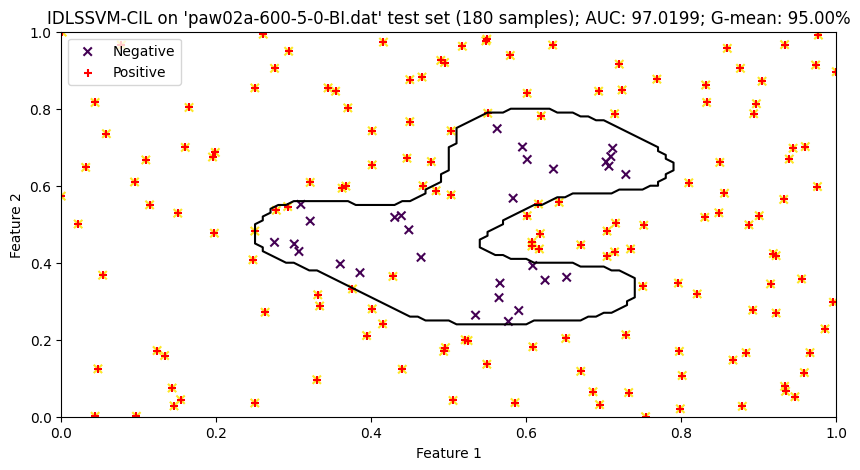

In [114]:
xx, yy = make_meshgrid(h=0.01)
X_meshgrid = np.c_[xx.ravel(), yy.ravel()]
if(model_no==0):
  y_pred_meshgrid = SVM_model.decision_function(X_meshgrid)
elif(model_no==1):
  y_pred_meshgrid = predict_lssvm(X_train, X_meshgrid, y_train, alpha, b, mu)
elif(model_no==2):
  y_pred_meshgrid = predict_idlssvmcil(X_train, X_meshgrid, y_train, alpha, b, mu)
y_pred_meshgrid = y_pred_meshgrid.reshape(xx.shape)

plot_title_3 = models[model_no] + " on '" + str(datasets[dataset_no]) + "' test set (" + str(df_test.shape[0]) + " samples); AUC: " + str('{:.4f}'.format(auc)) + "; G-mean: " + str('{:.2f}'.format(test_acc)) + "%"
plt.figure(figsize=(10, 5))
plt.contour(xx, yy, y_pred_meshgrid, levels=[0], colors='black', linestyles=['-'])
plt.scatter(df_test['feature1'], df_test['feature2'], c=y_test, marker='x', label='Negative')
plt.scatter(df_test['feature1'][y_test == 1], df_test['feature2'][y_test == 1], c='r', marker='+', label='Positive')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(plot_title_3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()